In [1]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('./data/train_mod.csv')
test = pd.read_csv('./data/test_mod.csv')

## Sin sampleo

In [3]:
train.set_index('id')

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,income_loan_ratio,person_home_ownership_ordinal,loan_intent_ordinal,loan_grade_ordinal,age_category_ordinal,emp_length_group_ordinal,person_home_ownership_freq,loan_intent_freq,loan_grade_freq,age_category_freq,emp_length_group_freq,person_home_ownership_target,loan_intent_target,loan_grade_target,age_category_target,emp_length_group_target
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,37,35000,0.0,6000,11.49,0.17,0,14,0,5.833333,3.0,1.0,1.0,0.0,1.0,0.521718,0.209254,0.347869,0.217627,0.645190,0.222575,0.107742,0.102314,0.141917,0.164781
1,22,56000,6.0,4000,13.35,0.07,0,2,0,14.000000,2.0,3.0,2.0,2.0,2.0,0.053516,0.186452,0.188192,0.778945,0.265208,0.013703,0.178176,0.135387,0.142354,0.107196
2,29,28800,8.0,6000,8.90,0.21,0,10,0,4.800000,2.0,4.0,0.0,2.0,2.0,0.053516,0.170780,0.357812,0.778945,0.265208,0.013703,0.132814,0.049187,0.142354,0.107196
3,30,70000,14.0,12000,11.11,0.17,0,5,0,5.833333,3.0,5.0,1.0,2.0,3.0,0.521718,0.170694,0.347869,0.778945,0.074185,0.222575,0.092816,0.102314,0.142354,0.080000
4,22,60000,2.0,6000,6.92,0.10,0,3,0,10.000000,3.0,3.0,0.0,2.0,1.0,0.521718,0.186452,0.357812,0.778945,0.645190,0.222575,0.178176,0.049187,0.142354,0.164781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,5.0,25000,15.95,0.21,1,10,0,4.800000,0.0,1.0,3.0,0.0,1.0,0.423248,0.209254,0.085816,0.217627,0.645190,0.059715,0.107742,0.593601,0.141917,0.164781
58641,28,28800,0.0,10000,12.73,0.35,0,8,1,2.880000,3.0,3.0,2.0,2.0,1.0,0.521718,0.186452,0.188192,0.778945,0.645190,0.222575,0.178176,0.135387,0.142354,0.164781
58642,23,44000,7.0,6800,16.00,0.15,0,2,1,6.470588,3.0,1.0,3.0,2.0,2.0,0.521718,0.209254,0.085816,0.778945,0.265208,0.222575,0.107742,0.593601,0.142354,0.107196


In [4]:
test_id = test['id']

In [5]:
X = train.drop(['loan_status'], axis=1)
y = train['loan_status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

vars_num = X_train.select_dtypes(include=['float64', 'int64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, vars_num),
])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

In [6]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10045
           1       0.77      0.56      0.65      1683

    accuracy                           0.91     11728
   macro avg       0.85      0.77      0.80     11728
weighted avg       0.91      0.91      0.91     11728

0.9131139154160982


In [7]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1_score_smote = f1_score(y_val, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score_smote)

Accuracy: 0.9131139154160982
Precision: 0.9068850653314693
Recall: 0.9131139154160982
F1 Score: 0.9070718910486284


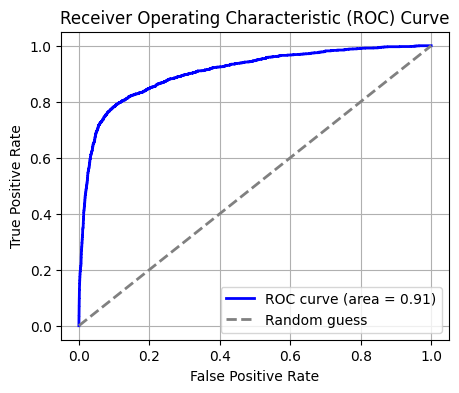

In [8]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


<Figure size 500x400 with 0 Axes>

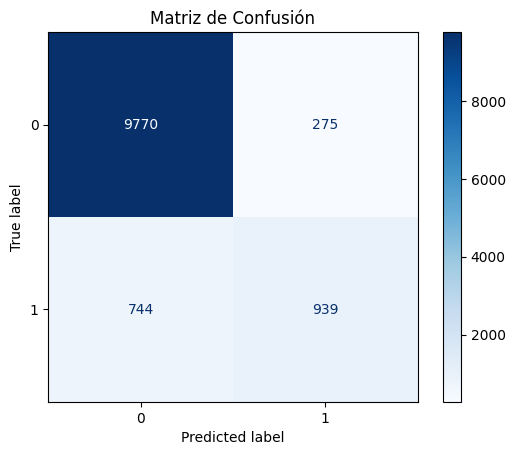

In [9]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

## Undersampling

In [10]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 40243, 1: 6666})
Resample dataset shape Counter({0: 6666, 1: 6666})


In [11]:
model.fit(x_rus, y_rus)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     10045
           1       0.46      0.83      0.59      1683

    accuracy                           0.84     11728
   macro avg       0.72      0.83      0.75     11728
weighted avg       0.89      0.84      0.85     11728

0.8378240109140518


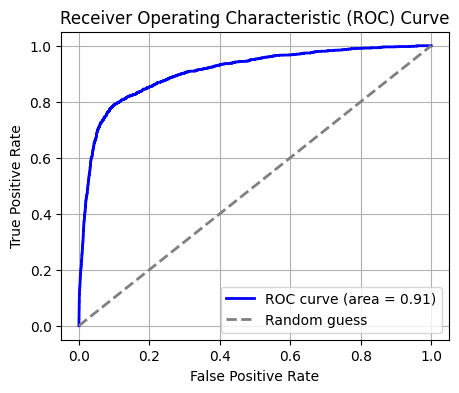

In [12]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

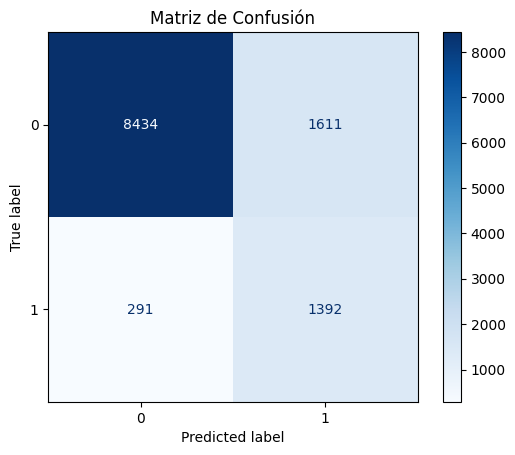

In [13]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

# Random Over Sampling

In [14]:
from imblearn.over_sampling import RandomOverSampler

smote = RandomOverSampler()
x_ros, y_ros = smote.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

original dataset shape: Counter({0: 40243, 1: 6666})
Resample dataset shape Counter({0: 40243, 1: 40243})


In [15]:
model.fit(x_ros, y_ros)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     10045
           1       0.47      0.83      0.60      1683

    accuracy                           0.84     11728
   macro avg       0.72      0.83      0.75     11728
weighted avg       0.89      0.84      0.86     11728

0.8397851296043656


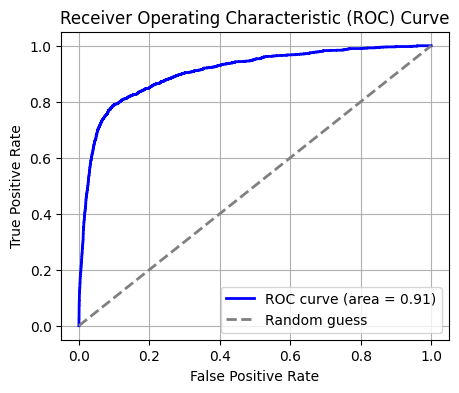

In [16]:
y_prob = model.predict_proba(X_val)[:, 1]  # Probabilidades para la clase positiva
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<Figure size 500x400 with 0 Axes>

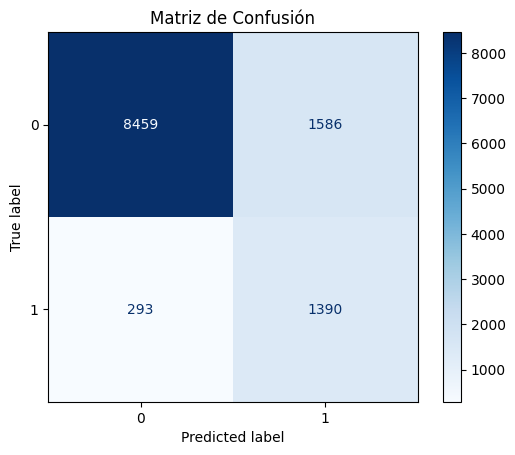

In [17]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(5, 4))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión')
plt.show()

# SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 40243, 1: 6666})
Resample dataset shape Counter({0: 40243, 1: 40243})


In [19]:
model.fit(x_smote, y_smote)
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     10045
           1       0.47      0.83      0.60      1683

    accuracy                           0.84     11728
   macro avg       0.72      0.84      0.75     11728
weighted avg       0.90      0.84      0.86     11728

0.842087312414734


In [20]:
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1_score_smote = f1_score(y_val, y_pred, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score_smote)

Accuracy: 0.842087312414734
Precision: 0.8959267139542484
Recall: 0.842087312414734
F1 Score: 0.8584202716066079


# Comparativa

In [21]:
model.fit(X_train, y_train)
predict_y = model.predict(X_val)

print('ROC-AUC score DF Original:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_rus, y_rus)
predict_y = model.predict(X_val)
print('ROC-AUC score Under-sampling:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_ros, y_ros)
predict_y = model.predict(X_val)
print('ROC-AUC score Over-sampling:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_smote, y_smote)
predict_y = model.predict(X_val)
print('ROC-AUC score SMOTE:',round(roc_auc_score(y_val, predict_y),2))

ROC-AUC score DF Original: 0.77
ROC-AUC score Under-sampling: 0.83
ROC-AUC score Over-sampling: 0.83
ROC-AUC score SMOTE: 0.84


In [22]:
model.fit(X_train, y_train)
predict_y = model.predict_proba(X_val)[:, 1]
print('ROC-AUC score DF Original:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_rus, y_rus)
predict_y = model.predict_proba(X_val)[:, 1]
print('ROC-AUC score Under-sampling:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_ros, y_ros)
predict_y = model.predict_proba(X_val)[:, 1]
print('ROC-AUC score Over-sampling:',round(roc_auc_score(y_val, predict_y),2))

model.fit(x_smote, y_smote)
predict_y = model.predict_proba(X_val)[:, 1]
print('ROC-AUC score SMOTE:',round(roc_auc_score(y_val, predict_y),2))

ROC-AUC score DF Original: 0.91
ROC-AUC score Under-sampling: 0.91
ROC-AUC score Over-sampling: 0.91
ROC-AUC score SMOTE: 0.91


#### Despues del feature engineering, el modelo no parece haber mejorado mucho (apenas).

### Guardar resultados de test para subir a kaggle

In [23]:
# Transformaciones
test = preprocessor.fit_transform(test)

In [24]:
y_pred = model.predict(test)

In [25]:
y_pred

array([1, 0, 1, ..., 0, 1, 1])

In [26]:
predictions = pd.DataFrame(y_pred)

In [27]:
predictions = predictions.reset_index().rename(columns={
    'index':'id',
    0:'loan_status'
})

In [28]:
predictions['id'] = test_id

In [29]:
predictions.head()

,id,loan_status
0,58645,1
1,58646,0
2,58647,1
3,58648,0
4,58649,1


In [30]:
# predictions.to_csv('baseline_predictions_features.csv', index=False)